<a href="https://colab.research.google.com/github/Salsabilaurelia1408/tugasakhirsalsa/blob/main/Tuning_Dropout(Short_ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout


In [30]:
def reshape_data(data, look_back):
    X = []
    Y = []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, :])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)

def create_gru_model(look_back, dropout):
    model = Sequential()
    model.add(GRU(50, activation='relu', input_shape=(look_back, 5)))
    model.add(Dense(1))
    model.add(Dropout(dropout))
    model.compile(optimizer='adam', loss='mse')
    return model

In [31]:
# Load data
url = 'https://raw.githubusercontent.com/Salsabilaurelia1408/tugasakhirsalsa/main/WOPR2_DateFormatRevised.csv'
df = pd.read_csv(url, index_col='Time', parse_dates=True)
df.set_index('Date', inplace=True)
df.index.freq = 'MS'

# Define input and output variables
X = df[['WOPR', 'WBHP', 'WWPR', 'WGPR', 'GOR']]
Y = df['WOPR']

GRU Dropout=0: Loss=0.001002383534796536, Loss_dev=0.00029056845232844353, Loss_train=0.00037230519228614867
GRU Dropout=0.1: Loss=0.00022675008221995085, Loss_dev=0.0013333470560610294, Loss_train=0.008116054348647594
GRU Dropout=0.2: Loss=0.00048475738731212914, Loss_dev=0.0005130950594320893, Loss_train=0.013348670676350594
GRU Dropout=0.3: Loss=0.0011221885215491056, Loss_dev=0.0025085145607590675, Loss_train=0.025402449071407318
GRU Dropout=0.4: Loss=0.002015457721427083, Loss_dev=0.004579664673656225, Loss_train=0.04009693115949631
GRU Dropout=0.5: Loss=0.0023771582636982203, Loss_dev=0.007165833842009306, Loss_train=0.08058086037635803


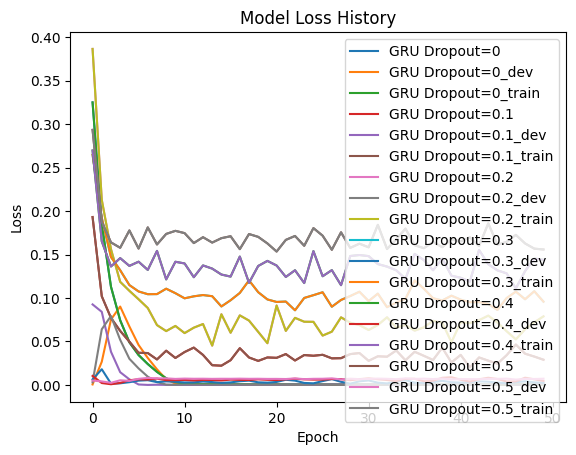

In [32]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
Y_scaled = scaler.fit_transform(np.array(Y).reshape(-1, 1))


# Define training and testing data
train_size = int(len(df) * 0.7)  # 80% for training, 20% for testing
dev_size = int(len(df)*0.15)
test_size = int(len(df)-(train_size+dev_size))

# Define training and testing data
look_back = 5
X_train = X_scaled[:train_size]
Y_train = Y_scaled[look_back:train_size + look_back]
X_dev = X_scaled[train_size:train_size + dev_size]
Y_dev = Y_scaled[train_size + look_back:train_size + dev_size + look_back]
X_test = X_scaled[train_size + dev_size:]
Y_test = Y_scaled[train_size + dev_size + look_back:]

X_train, Y_train = reshape_data(X_train, look_back)
X_dev, Y_dev = reshape_data(X_dev, look_back)
X_test, Y_test = reshape_data(X_test, look_back)

dropout_values = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
model_loss = []
model_loss_dev = []
model_loss_train = []

for dropout in dropout_values:
    model = create_gru_model(look_back, dropout)
    history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_dev, Y_dev), verbose=0, shuffle=False)
    loss = model.evaluate(X_test, Y_test, verbose=0)
    loss_dev = model.evaluate(X_dev, Y_dev, verbose=0)
    loss_train = model.evaluate(X_train, Y_train, verbose=0)
    model_loss.append(loss)
    model_loss_dev.append(loss_dev)
    model_loss_train.append(loss_train)
    
    # Print the loss value
    print(f"GRU Dropout={dropout}: Loss={loss}, Loss_dev={loss_dev}, Loss_train={loss_train}")

    # Plot the loss history of each model
    plt.plot(history.history['loss'], label=f"GRU Dropout={dropout}")
    plt.plot(history.history['val_loss'], label=f"GRU Dropout={dropout}_dev")
    plt.plot(history.history['loss'], label=f"GRU Dropout={dropout}_train")


plt.figure(figsize=(28,14))
plt.title('Model Loss History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()